# Gesture Recognition

Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

Each gesture corresponds to a specific command:

Gesture	Corresponding Action

Thumbs Up| Increase the volume. 

Thumbs Down| Decrease the volume. 

Left Swipe| 'Jump' backwards 10 seconds.

Right Swipe| 'Jump' forward 10 seconds. 

Stop| Pause the movie. 


# Objectives


Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [2]:
import numpy as np
import os
from skimage.transform import resize
# from scipy.misc import imresize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [5]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


- read the folder names for training and validation.
- set the batch_size here.

In [6]:
train_doc = np.random.permutation(open(r'D:\Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'D:\Project_data\val.csv').readlines())
batch_size = 64

In [7]:
!nvidia-smi

Mon Jul 25 15:04:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   46C    P8    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Generator

This is one of the most important part of the code. The overall structure of the generator has been given. 
In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 
You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [8]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [11]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [9]:
import cv2

def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [10]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [11]:
def getBatchData(source_path, t, batch, batch_size, img_tensor,augment=False):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    if (augment): batch_data_aug = np.zeros((batch_size,x,y,z,3))
    
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)
            if (augment):
                shifted = cv2.warpAffine(image, 
                                     np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),                                         (image.shape[1], image.shape[0]))
                    
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]
                image_resized=imresize(cropped,(y,z,3))
                    
                #shifted = cv2.warpAffine(image_resized, 
                #np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                #(image_resized.shape[1], image_resized.shape[0]))
            
                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
    return batch_data, batch_labels


In [12]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [22]:
import datetime

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = r'D:\Project_data\train'
val_path = r'D:\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [14]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


# Generator Validation

In [15]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, 20, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, 20, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  D:\Project_data\train ; batch size = 20
(20, 20, 100, 100, 3)
Source path =  D:\Project_data\val ; batch size = 20
(20, 20, 100, 100, 3)


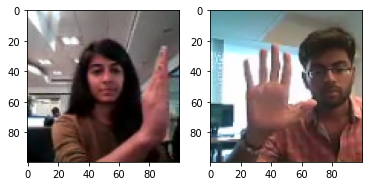

In [16]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[2,10,:,:,:])
plt.show()

In [17]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('No. of Epochs')
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('No. of Epochs')
    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

# Model Building
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Base Model

In [19]:
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                        

In [20]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model Callbacks Setup

In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

Test Batch Size & Frames

In [23]:
def testBatchSize(batch_size, n_frames):
    img_tensor = getImgTensor(n_frames)
    print("Using frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

With above observations, we can see that batch size is not impacting training time but number of frames. We will use batch size of 64 as it seems optimal. It is commented as it takes a lot of time to run that is restricting for the notebook to completely run

Model 1 - Frames-16, Epoc-20

In [46]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 23, 23, 32)    0         
 3D)                                                             
                                                          

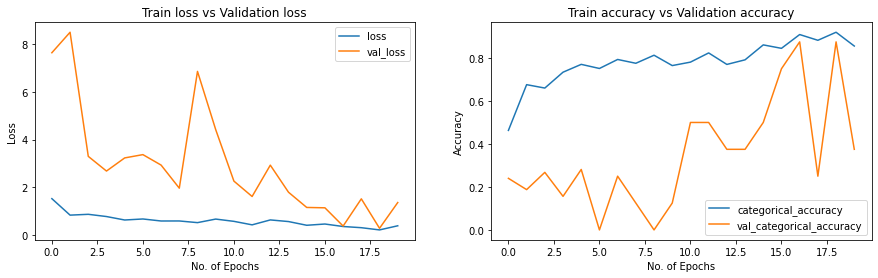

Max. Training Accuracy 0.9197860956192017
Max. Validaiton Accuracy 0.875


In [47]:
plotModelHistory(model1_history)

Model 2: Frames-20, Epocs-20

In [24]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 8, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                          

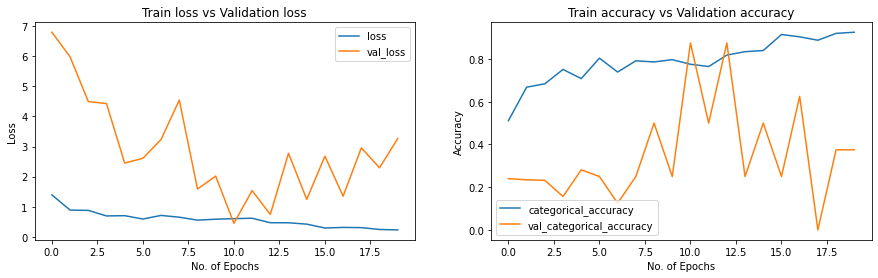

Max. Training Accuracy 0.9251337051391602
Max. Validaiton Accuracy 0.875


In [25]:
plotModelHistory(model2_history)

Model 3: Frames-30, Epocs-20, Reduced parameters

In [26]:
n_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 15, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 8, 25, 25, 32)    0         
 3D)                                                             
                                                          

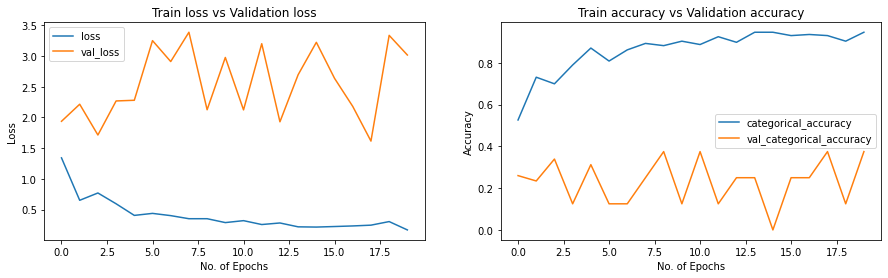

Max. Training Accuracy 0.9465240836143494
Max. Validaiton Accuracy 0.375


In [27]:
plotModelHistory(model3_history)

Model 4: Frames-20, Same pooling in Conv3D layer

In [28]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 10, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 5, 25, 25, 32)    0         
 g3D)                                                            
                                                          

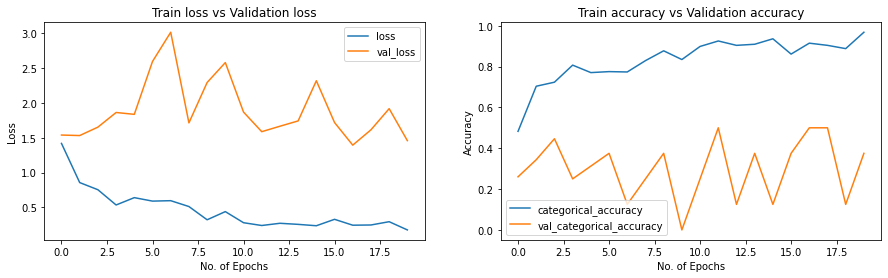

Max. Training Accuracy 0.9679144620895386
Max. Validaiton Accuracy 0.5


In [29]:
plotModelHistory(model4_history)

Model 5: Frames:20, Epocs-20, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling.

In [30]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d5")
model5.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Model: "conv_3d5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 20, 100, 100, 16)  400       
                                                                 
 batch_normalization_21 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 10, 50, 50, 32)    4128      
                                                                 
 batch_normalization_22 (Bat  (None, 10, 50, 50, 32)   128       
 chNormalization)                                                
                                                          

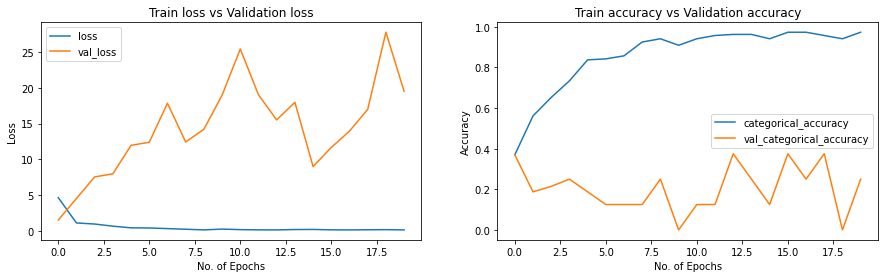

Max. Training Accuracy 0.9732620120048523
Max. Validaiton Accuracy 0.375


In [31]:
plotModelHistory(model5_history)

Model 6: Switching Model architecture to Conv2D+LSTM

In [32]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

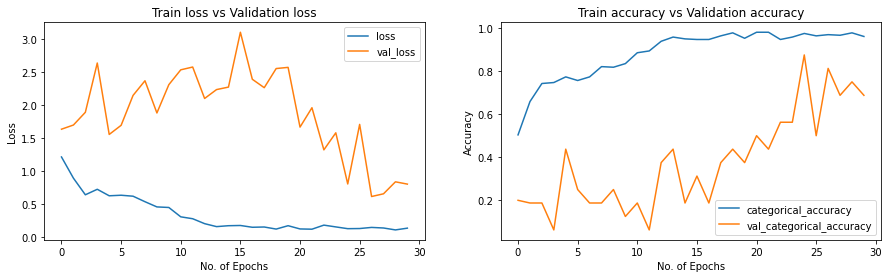

Max. Training Accuracy 0.9803921580314636
Max. Validaiton Accuracy 0.875


In [33]:
plotModelHistory(model6_history)

Model 7: Conv2D+LSTM with Reduced Parameters

In [35]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.25),

    Dense(256, activation='relu'),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_2d_lstm_reduced_params")
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm_reduced_params"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 50, 50, 32)   2080      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20

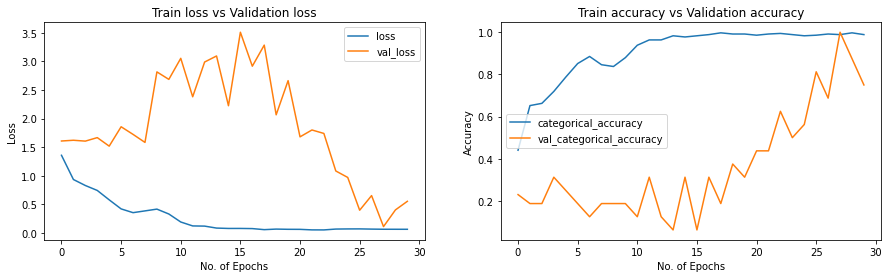

Max. Training Accuracy 0.9971988797187805
Max. Validaiton Accuracy 1.0


In [36]:
plotModelHistory(model7_history)